#**Topic Modeling** 
is a technique to extract the hidden topics from large volumes of text. Latent Dirichlet Allocation(LDA) is a popular algorithm for topic modeling with excellent implementations in the Python’s Gensim package. 

The challenge, however, is how to extract good quality of topics that are clear, segregated and meaningful. This depends heavily on the quality of text preprocessing and the strategy of finding the optimal number of topics.

# **LDA Mallet Model (NGRAMS)**

In this notebook, we present the approach of using **NGRAMS (1-gram, 2-grams and 3-grams)** apprach to build a LDA topic model using the LDA Mallet.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. We only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet.

## **Import Libraries, Packages and Data**

In [ ]:
!pip install --upgrade gensim==3.8

     |████████████████████████████████| 24.2 MB 1.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


**Install JAVA**

In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.14" 2022-01-18
OpenJDK Runtime Environment (build 11.0.14+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.14+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


**Install & Unpack LDA Mallet**

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2022-03-11 15:41:05--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-03-11 15:41:05--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  9.66MB/s    in 1.6s    

2022-03-11 15:41:07 (9.66 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 

**Import Libraries & Packages**

In [ ]:
!pip install pyLDAvis

import pandas as pd
import numpy as np
from pprint import pprint

import gensim
from gensim import corpora
from gensim.models import CoherenceModel

import string 
from nltk.tokenize import sent_tokenize, word_tokenize

import nltk
nltk.download('punkt')

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

     |████████████████████████████████| 1.7 MB 7.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=97d6dc70e85e19e421f162ee2ba42736857b6e6493cf9c934fc3629f3e129b31
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Mount to GDrive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Data**

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Hotel_Analysis/Hotel_Datasets/515k_Hotel_Reviews_NGRAMS_TOKENS.csv'
df = pd.read_csv(path)
df.head(5)

,cleaned_Reviews
0,"['backyard', 'hotel', 'total', 'mess', 'happen..."
1,"['cleaner', 'change', 'sheet', 'duvet', 'every..."
2,"['apart', 'price', 'brekfast', 'good']"
3,"['even', 'though', 'picture', 'show', 'clean',..."
4,"['aircondition', 'make', 'noise', 'hard', 'sle..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545181 entries, 0 to 545180
Data columns (total 1 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   cleaned_Reviews  545181 non-null  object
dtypes: object(1)
memory usage: 4.2+ MB


**10000 random samples for Topic Modelling**

In [ ]:
# Obtain a sample for topic model building

df_sample = df.sample(10000, random_state=120)

In [ ]:
# Reset index

df_sample = df_sample.reset_index(drop=True)

In [ ]:
df_sample

,cleaned_Reviews
0,"['good', 'service', 'gave_u_free', 'upgrade', ..."
1,"['room', 'immaculate', 'complimentary', 'bar',..."
2,"['star', 'hotel', 'room', 'shockingly', 'small..."
3,"['great', 'city', 'grea', 'thotel', 'great', '..."
4,"['front_desk', 'help', 'wonderful', 'true', 'd..."
...,...
9995,"['room', 'small', 'tiny', 'tiny', 'awfully', '..."
9996,"['staff', 'roof_terrace']"
9997,"['staff', 'grim', 'unhelpful']"
9998,"['get', 'little', 'loud', 'hotel', 'people', '..."


## **Reviews Pre-processing**

**Remove Punctuations**

In [ ]:
# Remove punctuations

df_sample["Reviews"] = df_sample['cleaned_Reviews'].str.replace('[^\w\s]','')

<input>:1: DeprecationWarning: invalid escape sequence \w
<ipython-input-12-1e9b69d4e2be>:1: DeprecationWarning: invalid escape sequence \w
  df_sample["Reviews"] = df_sample['cleaned_Reviews'].str.replace('[^\w\s]','')
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [ ]:
df_sample

,cleaned_Reviews,Reviews
0,"['good', 'service', 'gave_u_free', 'upgrade', ...",good service gave_u_free upgrade bottle bubble...
1,"['room', 'immaculate', 'complimentary', 'bar',...",room immaculate complimentary bar double showe...
2,"['star', 'hotel', 'room', 'shockingly', 'small...",star hotel room shockingly small literally fit...
3,"['great', 'city', 'grea', 'thotel', 'great', '...",great city grea thotel great people
4,"['front_desk', 'help', 'wonderful', 'true', 'd...",front_desk help wonderful true delight stay mo...
...,...,...
9995,"['room', 'small', 'tiny', 'tiny', 'awfully', '...",room small tiny tiny awfully outdated bathroom...
9996,"['staff', 'roof_terrace']",staff roof_terrace
9997,"['staff', 'grim', 'unhelpful']",staff grim unhelpful
9998,"['get', 'little', 'loud', 'hotel', 'people', '...",get little loud hotel people going evening com...


**Create Dataframe of Reviews**

In [ ]:
# Create dataframe of Reviews

reviews = df_sample.Reviews
reviews

0       good service gave_u_free upgrade bottle bubble...
1       room immaculate complimentary bar double showe...
2       star hotel room shockingly small literally fit...
3                     great city grea thotel great people
4       front_desk help wonderful true delight stay mo...
                              ...                        
9995    room small tiny tiny awfully outdated bathroom...
9996                                   staff roof_terrace
9997                                 staff grim unhelpful
9998    get little loud hotel people going evening com...
9999    breakfast best hotel used italy room large bed...
Name: Reviews, Length: 10000, dtype: object

**Convert reviews dataframe to list**

In [ ]:
# Convert reviews dataframe to list

reviews = reviews.tolist()

**Tokenize the sentence into words**

In [ ]:
# Tokenize the sentence into words

reviews_tokens = [word_tokenize(t) for t in reviews]

**Samples of reviews tokens**

In [ ]:
# Samples of reviews tokens

reviews_tokens[:5]

[['good',
  'service',
  'gave_u_free',
  'upgrade',
  'bottle',
  'bubble',
  'room',
  'victoria',
  'sponge',
  'thank'],
 ['room',
  'immaculate',
  'complimentary',
  'bar',
  'double',
  'shower',
  'view',
  'oxford_street',
  'angelica',
  'reception',
  'delightful',
  'done',
  'able',
  'shop',
  'come',
  'back',
  'rest',
  'shop',
  'going',
  'palladium',
  'wonderful',
  'dinner',
  'grill',
  'caught',
  'bus',
  'argyll',
  'street',
  'ten',
  'minute',
  'amazing'],
 ['star',
  'hotel',
  'room',
  'shockingly',
  'small',
  'literally',
  'fit',
  'bed',
  'table',
  'bathroom',
  'term',
  'little',
  'touch',
  'make',
  'star',
  'hotel',
  'experience',
  'bathrobe_slipper',
  'room',
  'made',
  'got',
  'back',
  'strangely',
  'pen',
  'commend',
  'spa',
  'yet',
  'short',
  'space'],
 ['great', 'city', 'grea', 'thotel', 'great', 'people'],
 ['front_desk',
  'help',
  'wonderful',
  'true',
  'delight',
  'stay',
  'morning',
  'brekfast',
  'delight',
  '

**Create a dictionary (mapping between words and their integer ids)**

In [ ]:
# Create a dictionary 
# mapping between words and their integer ids

dictionary = corpora.Dictionary(reviews_tokens)            

**Converts the word to its integer word id and returns the result as a sparse vector (using Doc2bow)**

In [ ]:
# The function doc2bow() simply counts the number of occurrences of each distinct word
# converts the word to its integer word id and returns the result as a sparse vector. 

doc_term_matrix = [dictionary.doc2bow(doc) for doc in reviews_tokens]

**Samples of doc_term_matrix (corpus)**

In [ ]:
# Samples of doc_term_matrix

doc_term_matrix[:5]

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1)],
 [(4, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 2),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1)],
 [(4, 2),
  (14, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 2),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 2),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1)],
 [(62, 1), (63, 1), (64, 2), (65, 1), (66, 1)],
 [(37, 1),
  (67, 1),
  (68, 2),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 2),
  (73, 1),
  (74, 1)]]

**Human readable format of corpus**

In [ ]:
# Human readable format of corpus

[[(dictionary[id], freq) for id, freq in cp] for cp in doc_term_matrix[:5]]

[[('bottle', 1),
  ('bubble', 1),
  ('gave_u_free', 1),
  ('good', 1),
  ('room', 1),
  ('service', 1),
  ('sponge', 1),
  ('thank', 1),
  ('upgrade', 1),
  ('victoria', 1)],
 [('room', 1),
  ('able', 1),
  ('amazing', 1),
  ('angelica', 1),
  ('argyll', 1),
  ('back', 1),
  ('bar', 1),
  ('bus', 1),
  ('caught', 1),
  ('come', 1),
  ('complimentary', 1),
  ('delightful', 1),
  ('dinner', 1),
  ('done', 1),
  ('double', 1),
  ('going', 1),
  ('grill', 1),
  ('immaculate', 1),
  ('minute', 1),
  ('oxford_street', 1),
  ('palladium', 1),
  ('reception', 1),
  ('rest', 1),
  ('shop', 2),
  ('shower', 1),
  ('street', 1),
  ('ten', 1),
  ('view', 1),
  ('wonderful', 1)],
 [('room', 2),
  ('back', 1),
  ('bathrobe_slipper', 1),
  ('bathroom', 1),
  ('bed', 1),
  ('commend', 1),
  ('experience', 1),
  ('fit', 1),
  ('got', 1),
  ('hotel', 2),
  ('literally', 1),
  ('little', 1),
  ('made', 1),
  ('make', 1),
  ('pen', 1),
  ('shockingly', 1),
  ('short', 1),
  ('small', 1),
  ('spa', 1),
  (

## **Model Building**

**Compute coherence score for models with different number of topics (Try from 2 topics - 40 topics)**

In [ ]:
# Compute coherence score for models with different number of topics
# Try from 2 topics - 40 topics

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=reviews_tokens, start=2, limit=40, step=2)

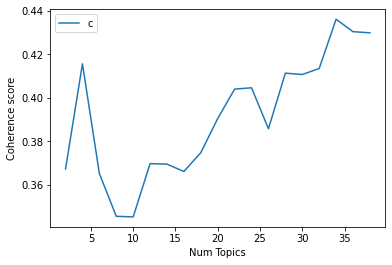

In [ ]:
# Show graph

limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show() 
sns.set(rc = {'figure.figsize':(15,8)})

In [ ]:
# Print the coherence scores for each topic

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3672
Num Topics = 4  has Coherence Value of 0.4156
Num Topics = 6  has Coherence Value of 0.3651
Num Topics = 8  has Coherence Value of 0.3454
Num Topics = 10  has Coherence Value of 0.3451
Num Topics = 12  has Coherence Value of 0.3697
Num Topics = 14  has Coherence Value of 0.3694
Num Topics = 16  has Coherence Value of 0.3661
Num Topics = 18  has Coherence Value of 0.3747
Num Topics = 20  has Coherence Value of 0.3905
Num Topics = 22  has Coherence Value of 0.404
Num Topics = 24  has Coherence Value of 0.4046
Num Topics = 26  has Coherence Value of 0.3857
Num Topics = 28  has Coherence Value of 0.4113
Num Topics = 30  has Coherence Value of 0.4107
Num Topics = 32  has Coherence Value of 0.4134
Num Topics = 34  has Coherence Value of 0.4361
Num Topics = 36  has Coherence Value of 0.4304
Num Topics = 38  has Coherence Value of 0.4299


Upon observation, we decided to go with Num Topics = 4, as at this number of topic, the coherence score of the model managed to achieve its highest at 0.4156. 

After this number of topics, the coherence score decreased significantly until it gradually increases again after reaching 20 number of topics. However, we will be choosing the least number of topic when it reached its highest score, hence, Num Topics = 4 was chosen.

## **Topic Model with Num Topic = 4**

In [ ]:
# Topic Model with Num Topic = 4 

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=4, id2word=dictionary)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('hotel', 0.10070640434351101),
   ('good', 0.08692860061883356),
   ('location', 0.07729581411641076),
   ('nice', 0.05108295872496935),
   ('clean', 0.036546208184949504),
   ('perfect', 0.019557475626131124),
   ('close', 0.019207192480588477),
   ('view', 0.018973670383560043),
   ('comfy', 0.016113024694961762),
   ('quiet', 0.01529569735536225)]),
 (1,
  [('breakfast', 0.09821008007536505),
   ('room', 0.05375647668393782),
   ('bed', 0.051695713612812055),
   ('bathroom', 0.028379651436646256),
   ('restaurant', 0.02219736222326896),
   ('shower', 0.01925341497880358),
   ('food', 0.01778144135657089),
   ('expensive', 0.013542157324540744),
   ('day', 0.013483278379651437),
   ('area', 0.01289448893075836)]),
 (2,
  [('room', 0.17243975903614459),
   ('small', 0.042516218721038),
   ('bar', 0.024096385542168676),
   ('night', 0.017145505097312327),
   ('time', 0.015639481000926783),
   ('price', 0.014712696941612605),
   ('size', 0.011758572752548655),
   ('floor', 0.01

**Convert to LDA format (to display pyLDAvis)**

In [ ]:
# Convert to LDA format (to display pyLDAvis)

lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

**Save & Load the model**

In [ ]:
# Save & Load the model

lda_model.save('/content/drive/MyDrive/Colab Notebooks/Hotel_Analysis/Models/LDAmallet_NGRAMS')
lda_model = gensim.models.ldamodel.LdaModel.load('/content/drive/MyDrive/Colab Notebooks/Hotel_Analysis/Models/LDAmallet_NGRAMS')

**Compute Coherence Score**

In [ ]:
# Compute Coherence Score

coherence_model_ldamodel = CoherenceModel(model=lda_model, texts=reviews_tokens, dictionary=dictionary, coherence='c_v')
coherence_ldamodel = coherence_model_ldamodel.get_coherence()
print('\nCoherence Score: ', coherence_ldamodel)


Coherence Score:  0.3728733309724392


## **Visualize the topics using pyLDAvis**

In [ ]:
# Visualize the topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary, sort_topics=False)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.234905  0.273885       1        1  24.964532
1      0.238258  0.172725       2        1  25.057185
2      0.270299 -0.182061       3        1  25.334032
3     -0.273653 -0.264549       4        1  24.644250, topic_info=            Term         Freq        Total Category  logprob  loglift
109        staff  2989.000000  2989.000000  Default  30.0000  30.0000
4           room  4391.000000  4391.000000  Default  29.0000  29.0000
91     breakfast  1890.000000  1890.000000  Default  28.0000  28.0000
45         hotel  1973.000000  1973.000000  Default  27.0000  27.0000
3           good  1667.000000  1667.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
522      english    56.914493    56.914493   Topic4  -5.8072   1.4006
185  cleanliness    85.929724    88.169288   Topic4  -5.3952   1.3749
5        service   422.952798   548.101978   Topic4  -3.8015   1.1414
263        decor   104.901222   115.103025   Topic4  -5.1957   1.3078
98      location  1082.491329  2565.082976   Topic4  -2.8617   0.5379

[244 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
11        4  0.999919    amazing
161       1  0.994512  amsterdam
12        3  0.886941   angelica
75        1  0.034992       area
75        2  0.964222       area
...     ...       ...        ...
121       4  0.998266       wifi
323       3  0.997000     window
37        1  1.003509  wonderful
313       2  1.001267       work
628       3  0.997809    working

[231 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

**Observation of Topics:**

Unfortunately, the topics that we obtained only gave us a very 'surface' understanding of the most mentioned topics in the reviews. Also, words like 'good', 'small', 'friendly' suggests that adjectives are present in our topic keywords, however, these words bring little to no value to us. We would attempt trying out the topic modelling using purely nouns in the LDA Mallet (NGRAMS + NOUNS) approach.